## In silico HIV SIU modeling with contact tracing and behavioral change on random geometric networks


In this notebook, I performed _in silico_ modeling of an HIV epidemic that is represented by a Susceptible-Infected-Undetected (SIU) model on a random geometric network. I then briefly analyzed the effect of the U compartment and the strict compliance to antiretroviral therapy (ART) in containing the spread.

### Model specifics

Given the current landscape of HIV, this disease can be properly represented by a SIU model instead of an SI model. The U compartment represents those having undetected levels of HIV on their bodies. These people have undergone ART to ensure that the HIV levels remain undetected, a.k.a. the U=U (undetectable = untransmittable) premise. Note that once in the U state, the individual cannot return to the S state. Contact tracing is also included to represent the efforts made by local health units to detect individuals having HIV as well as informing their past sexual contacts. Random geometric networks are characterized by their radii, in a way that two nodes are connected if their distance is within the latter. 


The SIU model begins with selecting $\nu$ nodes ($\nu \in [1, len(I_{0})]$) where $I_{0}$ is the set of initially infected nodes (given by the fraction $i_{0}$). For each node $Z$ in {$\nu$}, it will select $\epsilon$ neighbors ($\epsilon \in [1, len(neighbors)]$) to have sexual contact/s. 

Let's go to the specifics of the model. <br>
1. initial fraction infected $i_{0}$ = 0.05 <br>
2. network size $N$ = 1000 <br>
3. iterations $t_{max}$ = 50 (for faster runtime) <br>
4. transmission probability $	au$ = 0.1
5. contact tracing probability $p_{ct}$ = 0.8
6. behavioral change probability $p_{b}$ = 0.8
7. ART effectiveness probability $p_{art}$ -> consider 0.9 (strict compliance) and 0.1 (little compliance)
8. radius $r \in [0.005, 0.8]$

Average final infection sizes $\Omega$ (the fraction infected at $t_{max}$) will be computed over 2 samples.

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.4 MB/s eta 0:00:00:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python3 -m pip install --upgrade pip


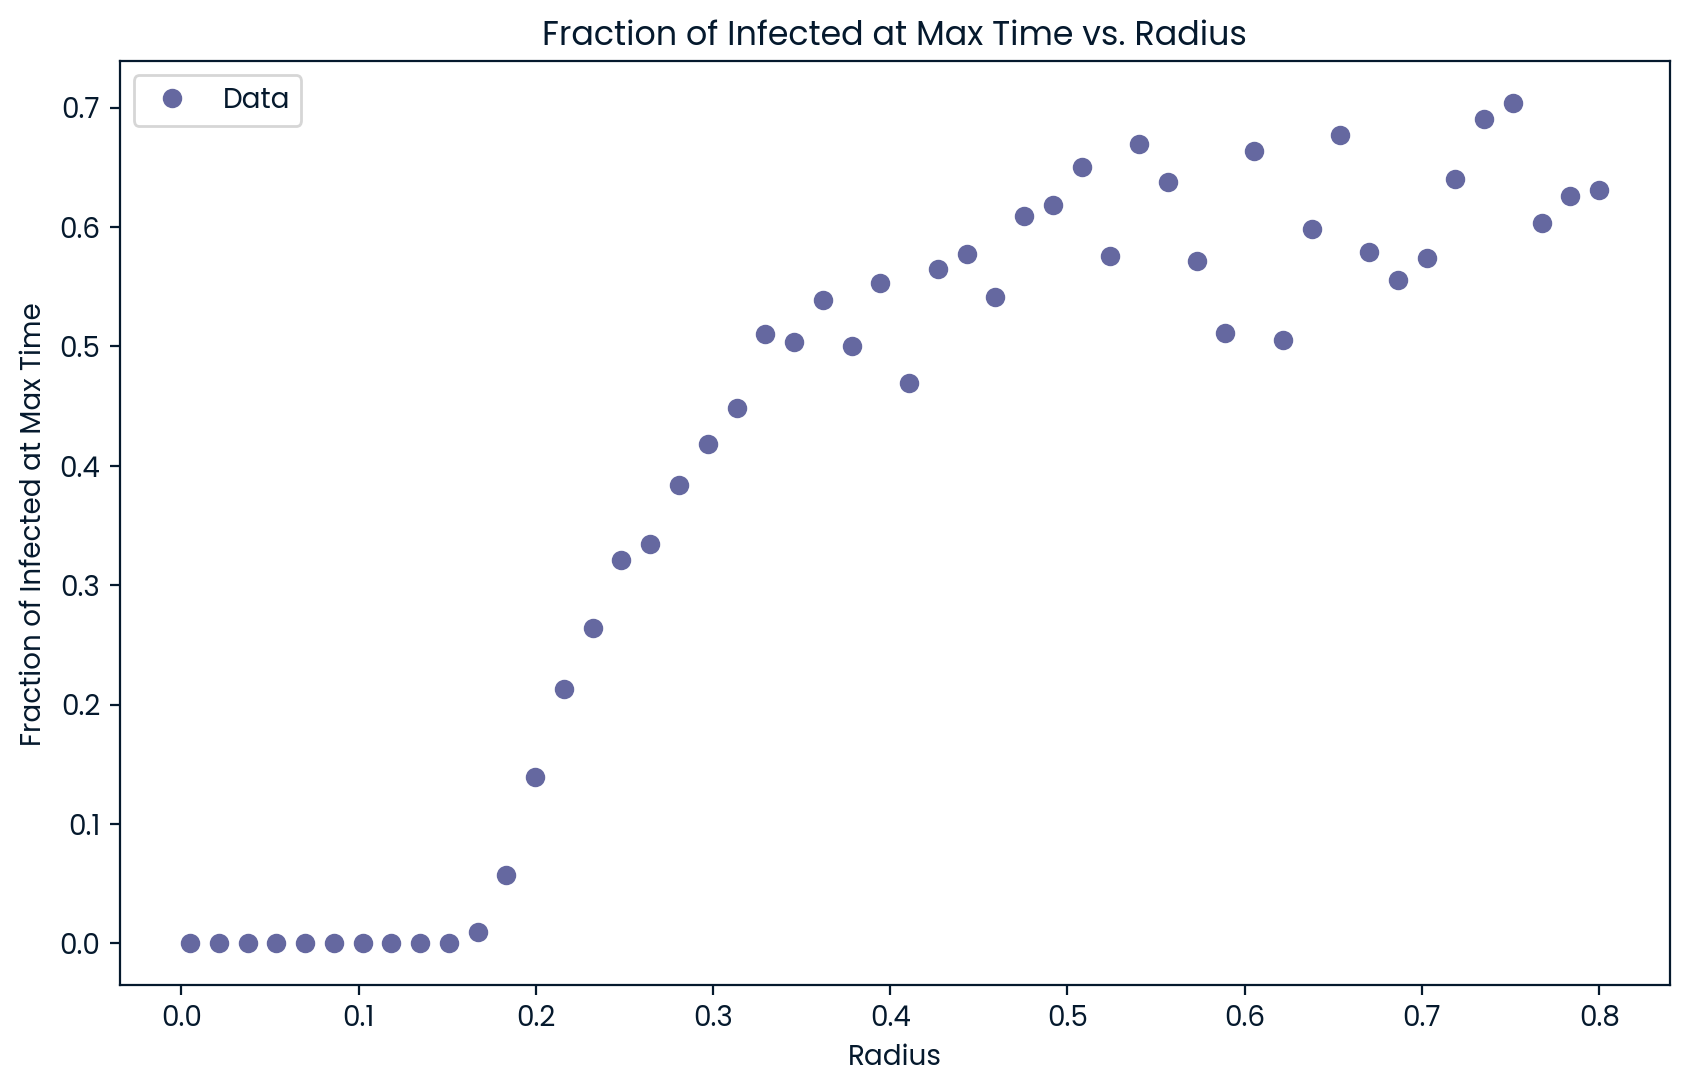

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random

try:
    import igraph as ig
except ImportError:
    !pip install python-igraph
    import igraph as ig
from multiprocessing import Pool, cpu_count

def simulate_hiv_infection(n, radius, initial_infected_fraction, max_iterations, transmission_prob, contact_tracing_prob, behavior_change_prob, art_effectiveness_prob):
    # Create a random geometric graph
    g = ig.Graph.GRG(n, radius)
    
    # Initialize states: 0 = Susceptible (S), 1 = Infected (I), 2 = Undetectable (U)
    states = np.zeros(n, dtype=int)
    behavior_changed = np.zeros(n, dtype=bool)  # Track behavior change
    
    # Randomly infect a fraction of the population
    initial_infected = set(random.sample(range(n), int(initial_infected_fraction * n)))
    for node in initial_infected:
        states[node] = 1
    
    # Precompute neighbors for each node
    neighbors = [g.neighbors(node) for node in range(n)]
    
    # Run the simulation
    for _ in range(max_iterations):
        new_states = states.copy()
        num_sex = random.randint(1, len(initial_infected))
        sex_nodes = random.sample(initial_infected, num_sex)
        
        for node in sex_nodes:
            if states[node] == 1:  # If the node is infected
                node_neighbors = neighbors[node]  # Use precomputed neighbors
                if node_neighbors:
                    num_contacts = random.randint(1, len(node_neighbors))
                    contact_nodes = random.sample(node_neighbors, num_contacts)
                    
                    for contact in contact_nodes:
                        if states[contact] == 0:  # If the contact is susceptible
                            effective_transmission_prob = transmission_prob
                            if behavior_changed[node] or behavior_changed[contact]:
                                effective_transmission_prob *= (1 - behavior_change_prob)
                            if random.random() < effective_transmission_prob:
                                new_states[contact] = 1
                                initial_infected.add(contact)
                        elif states[contact] == 2:  # If the contact is undetectable
                            effective_transmission_prob = transmission_prob * (1 - art_effectiveness_prob)
                            if behavior_changed[node] or behavior_changed[contact]:
                                effective_transmission_prob = transmission_prob * max(1 - behavior_change_prob, 1 - art_effectiveness_prob)
                            if random.random() < effective_transmission_prob:
                                new_states[contact] = 1
                                initial_infected.add(contact)
                
                # Move to undetectable state with ART effectiveness probability
                if random.random() < art_effectiveness_prob:
                    new_states[node] = 2
        
        # Contact tracing and behavior change
        for node in sex_nodes:
            if states[node] == 1:
                node_neighbors = neighbors[node]  # Use precomputed neighbors
                for neighbor in node_neighbors:
                    if random.random() < contact_tracing_prob:
                        if random.random() < behavior_change_prob:
                            behavior_changed[neighbor] = True
        
        states = new_states
    
    # Return the final states
    return states

def simulate_for_radius(args):
    n, radius, initial_infected_fraction, max_iterations, transmission_prob, contact_tracing_prob, behavior_change_prob, art_effectiveness_prob, samples = args
    infected_fractions = []
    for _ in range(samples):
        final_states = simulate_hiv_infection(n, radius, initial_infected_fraction, max_iterations, transmission_prob, contact_tracing_prob, behavior_change_prob, art_effectiveness_prob)
        infected_fraction = np.sum(final_states == 1) / n
        infected_fractions.append(infected_fraction)
    
    average_infected_fraction = np.mean(infected_fractions)
    return average_infected_fraction

def plot_fraction_infected_vs_radius(n, radii, initial_infected_fraction, max_iterations, transmission_prob, contact_tracing_prob, behavior_change_prob, art_effectiveness_prob, samples=2):
    radius_args = [(n, radius, initial_infected_fraction, max_iterations, transmission_prob, contact_tracing_prob, behavior_change_prob, art_effectiveness_prob, samples) for radius in radii]
    
    with Pool(cpu_count()) as pool:
        fractions = pool.map(simulate_for_radius, radius_args)
    
    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(radii, fractions, 'o', label='Data')
    
    plt.xlabel('Radius')
    plt.ylabel('Fraction of Infected at Max Time')
    plt.legend()
    plt.title('Fraction of Infected at Max Time vs. Radius')
    # plt.xscale('log')
    # plt.yscale('log')
    plt.show()

n = 1000
radii = np.linspace(0.005, 0.8, 50)
initial_infected_fraction = 0.05
max_iterations = 50
transmission_prob = 0.1
contact_tracing_prob = 0.8
behavior_change_prob = 0.8
art_effectiveness_prob = 0.9

plot_fraction_infected_vs_radius(n, radii, initial_infected_fraction, max_iterations, transmission_prob, contact_tracing_prob, behavior_change_prob, art_effectiveness_prob)

The plot reveals that with $p_{art}$ set sufficiently high, the infection was "contained" at around 0.7 (70% of the population infected). Let's consider the case where there is little compliance to ART: $p_{ART} = 0.1$.

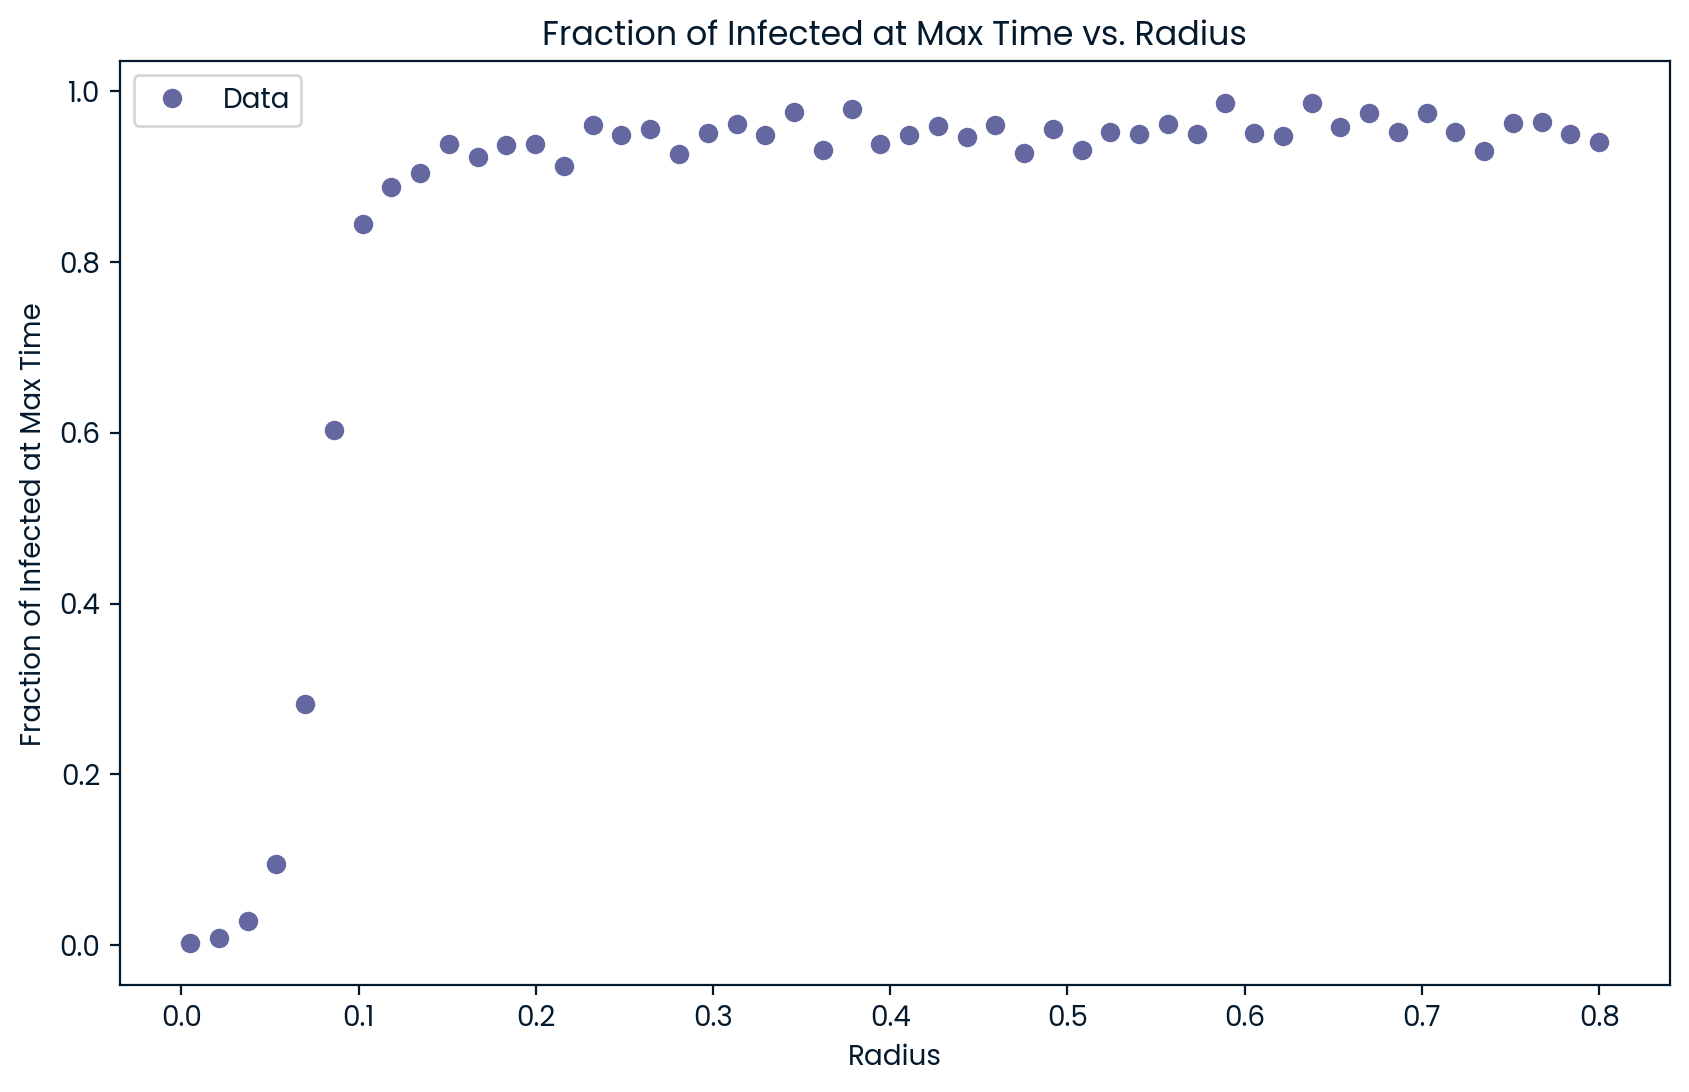

In [3]:
art_effectiveness_prob2 = 0.1

plot_fraction_infected_vs_radius(n, radii, initial_infected_fraction, max_iterations, transmission_prob, contact_tracing_prob, behavior_change_prob, art_effectiveness_prob2)

Notice the difference? With little compliance to ART, the infection was not contained despite contact tracing efforts.

This modeling initiative is an open work. Areas that I'd like to explore next include the possibility of infusing the use of condoms and PrEP. Another one is to include the notion that the person in U state may return to the I state. Lastly, I'm keen on tinkering around various parameter combinations. 

If you have questions in mind, send them over at jprmaulion[at]gmail[dot]com. Cheers!